# Importing Libraries

In [1]:
#---------------------------------------------------------------------------------------------------------------------
#warnings
import warnings
warnings.filterwarnings('ignore')

#---------------------------------------------------------------------------------------------------------------------
#data analysis and visualizations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")


#---------------------------------------------------------------------------------------------------------------------
#linear modelling
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from lazypredict.Supervised import LazyRegressor


#---------------------------------------------------------------------------------------------------------------------
#classification modelling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from lazypredict.Supervised import LazyClassifier


#---------------------------------------------------------------------------------------------------------------------
#data manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import scipy.stats as st #for boxcox


#---------------------------------------------------------------------------------------------------------------------
#model metrics
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, classification_report, roc_curve


#---------------------------------------------------------------------------------------------------------------------
#feature selection
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import f_regression, VarianceThreshold, SelectKBest, SelectPercentile, chi2, f_classif


#---------------------------------------------------------------------------------------------------------------------
#outliers
from collections import Counter #for IQR method
from scipy.stats import median_abs_deviation #for modified z-score
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN


#---------------------------------------------------------------------------------------------------------------------
#model selection
from sklearn.model_selection import cross_val_score, GridSearchCV


# Helping Functions

In [2]:


#calculate adjusted r2
def m_adjusted_r2(obs_num, var_num,r2):
    return (1-(1-r2)*((obs_num-1)/(obs_num-var_num-1)))

#show features regression in Dataframe
def m_fregression(x,y):
    features_regression = pd.DataFrame(columns=['feature','coefficient','pval'])
    for i in range (x.shape[1]):
        df_f_regression = f_regression(x,y)
        row = {'feature':x.columns[i],'coefficient':df_f_regression[0][i].round(2),'pval':df_f_regression[1][i].round(5)}
        features_regression = features_regression.append(row,ignore_index=True)
    return (features_regression)

#calculating multicolinearity between variables
def m_VIF(x,y):
    #get columns names
    a = x.columns
    b = y.columns
    
    #loop to generate a (specially-formated) string containing (dependant variable) and (independent variables)
    string_fun = '{}~'.format(b[0])
    for i in range(0,len(a),1):
        string_fun = string_fun+"{}+".format(a[i])
        
    #to drop the last (+)
    string_fun= string_fun[0:len(string_fun)-1]
    string_fun
    
    #generate a full dataframe containing dependent and independent variables
    df_vif_gen = pd.merge(left=y,right=x,left_index=True,right_index=True)
    
    
    #find design matrix for regression model using 'rating' as response variable 
    y,x = dmatrices(string_fun, data=df_vif_gen, return_type='dataframe')

    #create DataFrame to hold VIF values
    vif_df = pd.DataFrame()
    vif_df['variable'] = x.columns 

    #calculate VIF for each predictor variable 
    vif_df['VIF'] = np.round([variance_inflation_factor(x.values, i) for i in range(x.shape[1])],2)

    #view VIF for each predictor variable 
    print ('VIF=1: There is no correlation between a given predictor variable and any other predictor variables in the model.\n')
    print ('VIF=(1-5): There is moderate correlation between a given predictor variable and other predictor variables in the model.\n')
    print ('VIF>5: There is severe correlation between a given predictor variable and other predictor variables in the model.')

    return vif_df

# find correlated features
def m_correlation(dataset, threshold):
    col_corr = []  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.append(colname)
    return col_corr

#reduce dataframe by quantile value (outlier), return the reduced dataframe and print the curve
def m_df_trim (dataframe,column_name,q_low,q_high):   
    q_low = dataframe[column_name].quantile(q=q_low)
    q_high = dataframe[column_name].quantile(q=q_high)

    df_reduced = dataframe[(dataframe[column_name]>q_low)&(dataframe[column_name]<=q_high)]
    print (np.round(100-df_reduced.shape[0]/dataframe.shape[0]*100,2),"% of data will be lost")
    fig, ax = plt.subplots(figsize=(15,5),nrows=1,ncols=2);
    sns.histplot(data=dataframe,x=column_name,ax=ax[0],label='Original');
    sns.histplot(data=df_reduced,x=column_name,ax=ax[1],label='Reduced')
    ax[0].legend()
    ax[1].legend()
    return df_reduced

#creating different linear regression models and a dataframe containing the summary info
def m_mlinear_regression(xtr,xts,ytr,yts):
#create a dataframe for modeling summary 
    models_summary = pd.DataFrame(columns=['Model','Type','Scaled','R2-Score','RMSE-Score'])

    #multiple linear regression
    model = LinearRegression()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Linear'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    
    #support vector regression
    model_variables=['rbf','linear','poly','sigmoid']
    for i in model_variables:
        model = SVR(kernel=i)
        model.fit(xtr,ytr)
        ypr = model.predict(xts)
        #
        model_name='SVR'
        model_type=i
        scaled='No'
        score = r2_score(yts,ypr)
        score2=mean_squared_error(yts,ypr,squared=False)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #Decision treeregression
    model = DecisionTreeRegressor()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Decision tree'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #Random forest regression
    model_variables = [100,200,300,400,500]
    for i in model_variables:
        model = RandomForestRegressor(n_estimators=i)
        model.fit(xtr,ytr)
        ypr = model.predict(xts)
        #
        model_name='Random forest'
        model_type=i
        scaled='No'
        score = r2_score(yts,ypr)
        score2=mean_squared_error(yts,ypr,squared=False)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #XGBoost
    model = XGBRegressor()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='XGBoost'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)
    
    #Lasso
    model = Lasso()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Lasso'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #Ridge
    model = Ridge()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Ridge'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #KernelRidge
    model = KernelRidge()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='KernelRidge'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #BayesianRidge
    model = BayesianRidge()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='BayesianRidge'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #ElasticNet
    model = ElasticNet()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='ElasticNet'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)


    
#---------------SCALING-------------------#
    sc    = StandardScaler()              #
    xtr_sc= sc.fit_transform(xtr)         #
    xts_sc= sc.transform(xts)             #
#-----------------------------------------#
    #multiple linear regression
    model = LinearRegression()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Linear'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    
    #support vector regression
    model_variables=['rbf','linear','poly','sigmoid']
    for i in model_variables:
        model = SVR(kernel=i)
        model.fit(xtr_sc,ytr)
        ypr = model.predict(xts_sc)
        #
        model_name='SVR'
        model_type=i
        scaled='Yes'
        score = r2_score(yts,ypr)
        score2=mean_squared_error(yts,ypr,squared=False)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #Decision treeregression
    model = DecisionTreeRegressor()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Decision tree'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #Random forest regression
    model_variables = [100,200,300,400,500]
    for i in model_variables:
        model = RandomForestRegressor(n_estimators=i)
        model.fit(xtr_sc,ytr)
        ypr = model.predict(xts_sc)
        #
        model_name='Random forest'
        model_type=i
        scaled='Yes'
        score = r2_score(yts,ypr)
        score2=mean_squared_error(yts,ypr,squared=False)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #XGBoost
    model = XGBRegressor()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='XGBoost'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)

    #Lasso
    model = Lasso()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Lasso'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)
    
    #Ridge
    model = Ridge()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Ridge'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)
    
    #KernelRidge
    model = KernelRidge()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='KernelRidge'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)
    
    #BayesianRidge
    model = BayesianRidge()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='BayesianRidge'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)
    
    #ElasticNet
    model = ElasticNet()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='ElasticNet'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    score2=mean_squared_error(yts,ypr,squared=False)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'R2-Score':score,'RMSE-Score':score2},ignore_index=True)
    models_summary['R2-Score']=models_summary['R2-Score'].round(3)
    models_summary['RMSE-Score']=models_summary['RMSE-Score'].round(3)
            
    model_summary = models_summary.sort_values(by=['RMSE-Score'],ascending=True)
    model_summary.reset_index(inplace=True)
    return model_summary


def m_mlog_regression(xtr, xts, ytr, yts):
    models_summary = pd.DataFrame(columns=['Model','Type','Scaled','Score'])
    
    #Logistic regression
    model=LogisticRegression()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='Logistic'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)
    #Kneighbors classifier
    model=KNeighborsClassifier()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='Kneighbors'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)
    #Gaussian NB
    model=GaussianNB()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='GaussianNB'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)
    #Support Verctor Classifier
    model=SVC()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='SVC'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)
    #Decision Tree Classifier
    model=DecisionTreeClassifier()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='DecisionTree'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)
    #Random Forest Classifier
    model=RandomForestClassifier()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='RandomForest'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)

    #XGB Classifier
    model=XGBClassifier()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='XGB Classifier'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)

    #LGBM Classifier
    model=LGBMClassifier(verbose=-1)
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='LGBM Classifier'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)

    #CatBoost Classifier()
    model=CatBoostClassifier(verbose=False)
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    model_name='CatBoost Classifier'
    model_type='General'
    model_scale='Yes'
    model_score= accuracy_score(yts,ypr)
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,
                                            'Scaled':model_scale,'Score':model_score},ignore_index=True)

    models_summary = models_summary.sort_values(by=['Score'],ascending=False)
    models_summary.reset_index(inplace=True)

    return models_summary

#return a list and graph of how features importance to target value
def m_feature_importance (xtrain,ytrain,n_estimators):
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(xtrain,ytrain)
    df_features_importance = pd.DataFrame({'features':xtrain.columns,'importance':rf.feature_importances_})
    df_features_importance.sort_values(by='importance',axis=0,inplace=True,ascending=False)
    sns.barplot(x=df_features_importance['importance'],
                y=df_features_importance['features'],
                color='b')  
    return df_features_importance

#list the features which have correlation of specific values against the rest of dataset features
def m_corr_list(df,min_up=0.6,min_down=-0.6):
    corr_mat=df.corr()
#loop through orrelation-matrix rows
    for x in corr_mat.index:
        #list for features having positive correlation against first feature
        corr_feat_up=[]
        #list for features having negative correlation against first feature
        corr_feat_down=[]
        
        #add features which have correlation in the specified limits
        for y in corr_mat.columns:
            if (corr_mat.loc[x,y]>=min_up) and (x!=y): #skip feature against same feature
                corr_feat_up.append(y)
            elif (corr_mat.loc[x,y]<=min_down) and (x!=y): #skip feature against same feature
                corr_feat_down.append(y)
        if len(corr_feat_up)!=0:
            print ('\033[1m'+x+'\033[0m'+' is positively correlated with {}'.format(corr_feat_up))
        if len(corr_feat_down)!=0:
            print ('\033[1m'+x+'\033[0m'+' is negatively correlated with {}'.format(corr_feat_down))
        if len(corr_feat_up)!=0 or len(corr_feat_down)!=0:
            print ('')           

#return a list and graph of how features importance to target value
def m_feature_importance (xtrain,ytrain,n_estimators):
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(xtrain,ytrain)
    df_features_importance = pd.DataFrame({'features':xtrain.columns,'importance':rf.feature_importances_})
    df_features_importance.sort_values(by='importance',axis=0,inplace=True,ascending=False)
    sns.barplot(x=df_features_importance['importance'],
                y=df_features_importance['features'],
                color='b')  
    return df_features_importance

#split dataframe into target variable and features
def m_xy_split(df,target_column):
    col = (df.columns).drop(target_column)
    y = df[[target_column]]
    x = df[col]
    return x,y

def m_scale_encode_split(dftrain,target_feature,num_feature,cat_feature,train_size=0.85,dftest=None,encode_target=0):
    """
    ** Returns xtr_sc,xts_sc,ytr,yts,dfts_sc
    ** dftest is not none: will scale test dataset at same scale of training dataset
    ** To encode target variable, encode_target=1
    ** To scale whole train dataset: train_size=100
    """
    #separating target variable and features
    df=dftrain
    while target_feature in num_feature:
        my_list.remove(target_feature)
    while target_feature in cat_feature:
        my_list.remove(target_feature)
    y_ml=df[target_feature]
    x_ml=df[num_feature+cat_feature]

    #Encoding categorical features
    x_ml_dum = pd.get_dummies(x_ml,columns=cat_feature,drop_first=True)
    
    if encode_target==1:
        y_ml_dum=pd.get_dummies(y_ml,drop_first=True)
        y_ml=y_ml_dum.copy()
        
    if train_size != 100:
        #splitting data
        xtr,xts,ytr,yts=train_test_split(x_ml_dum,y_ml,train_size=train_size)
    else:
        xtr = x_ml_dum
        xts = xtr.copy()
        ytr = y_ml
        yts = ytr.copy()

    #Scaling numerical features
    xtr_sc=xtr.copy()
    xts_sc=xts.copy()
    sc=StandardScaler()
    xtr_sc[num_feature]=sc.fit_transform(xtr[num_feature])
    xts_sc[num_feature]=sc.transform(xts[num_feature])
    
    
    if dftest is None:
        print ("train size is {}".format(train_size))
        return xtr_sc,xts_sc,ytr,yts
    
    else:
        dfts=dftest[num_feature+cat_feature]
        dfts_dum = pd.get_dummies(dfts,columns=cat_feature,drop_first=True)
        dfts_sc=dfts_dum.copy()
        dfts_sc[num_feature]=sc.transform(dfts_sc[num_feature])
        print ("train size is {}%".format(train_size))
        return xtr_sc,xts_sc,ytr,yts,dfts_sc

#from collections import Counter #for IQR method
def m_outlier_iqr (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
                
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] < Q1 - outlier_step]
    df2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of outliers is:', df1.shape[0]+df2.shape[0])
    print('Total number of observations containing more than {} outliers is: {} '.format(n,len(multiple_outliers)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(multiple_outliers)/df.shape[0]*100,0)))
    
    return multiple_outliers

def m_outlier_std (df,n,features):
    """
    Takes a dataframe df of features and returns an index list corresponding to the observations 
    containing more than n outliers according to the standard deviation method.
    """
    outlier_indices = []
    
    for column in features:
        # calculate the mean and standard deviation of the data frame
        data_mean = df[column].mean()
        data_std = df[column].std()
        
        # calculate the cutoff value
        cut_off = data_std * 3
        
        # Determining a list of indices of outliers for feature column        
        outlier_list_column = df[(df[column] < data_mean - cut_off) | (df[column] > data_mean + cut_off)].index
        
        # appending the found outlier indices for column to the list of outlier indices 
        outlier_indices.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > data_mean + cut_off]
    df2 = df[df[column] < data_mean - cut_off]
    print('Total number of outliers is:', df1.shape[0]+ df2.shape[0])
    print('Total number of observations containing more than {} outliers is: {} '.format(n,len(multiple_outliers)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(multiple_outliers)/df.shape[0]*100,0)))
    
    return multiple_outliers   

#from scipy.stats import median_abs_deviation #for modified z-score
def m_outlier_zscore (df,n,features):
    """
    Takes a dataframe df of features and returns an index list corresponding to the observations 
    containing more than n outliers according to the z-score method.
    """
    outlier_list = []
    
    for column in features:
        # calculate the mean and standard deviation of the data frame
        data_mean = df[column].mean()
        data_std = df[column].std()
        threshold = 3
        
        z_score = abs( (df[column] - data_mean)/data_std )
        
        # Determining a list of indices of outliers for feature column        
        outlier_list_column =  df[z_score > threshold].index
        
        # appending the found outlier indices for column to the list of outlier indices 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of outlier records
    df1 = df[z_score > threshold]
    print('Total number of outliers is:', df1.shape[0])
    print('Total number of observations containing more than {} outliers is: {} '.format(n,len(multiple_outliers)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(multiple_outliers)/df.shape[0]*100,0)))
    
    return multiple_outliers

def m_outlier_zscore_modified (df,n,features):
    """
    Takes a dataframe df of features and returns an index list corresponding to the observations 
    containing more than n outliers according to the z-score modified method.
    """
    outlier_list = []
    
    for column in features:
        # calculate the mean and standard deviation of the data frame
        data_mean = df[column].mean()
        data_std = df[column].std()
        threshold = 3
        MAD = median_abs_deviation
        
        mod_z_score = abs(0.6745*(df[column] - data_mean)/MAD(df[column]) )
                
        # Determining a list of indices of outliers for feature column        
        outlier_list_column =  df[mod_z_score >threshold].index
        
        # appending the found outlier indices for column to the list of outlier indices 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of outlier records
    df1 = df[mod_z_score >threshold]
    print('Total number of outliers is:', df1.shape[0])
    print('Total number of observations containing more than {} outliers is: {} '.format(n,len(multiple_outliers)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(multiple_outliers)/df.shape[0]*100,0)))
    
    return multiple_outliers

#from sklearn.ensemble import IsolationForest
def m_outlier_isolationforest(df,features=[]):
    df=df[features]
    outlier_model = IsolationForest()
    outlier_model.fit(df)
    anomaly = outlier_model.predict(df)
    df['anomaly'] = anomaly
    print ('The total number of outliers is: ',df[(df['anomaly']==-1)]['anomaly'].count())
    print('Percentage of data to be lost is: %{}'.format(np.round(df[(df['anomaly']==-1)]['anomaly'].count()/df.shape[0]*100,0)))

    return df

#from sklearn.cluster import DBSCAN
def m_outlier_DBSCAN(df,features=[]):
    df=df[features]
    sc = StandardScaler()
    df_sc = sc.fit_transform(df)
    model_DBSCAN = DBSCAN()
    model_DBSCAN.fit(df_sc)
    labels = model_DBSCAN.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    labels = pd.Series(labels)
    print ('The total number of clusters without outliers: ',n_clusters)
    print ('The number of outliers is: ',labels[(labels==-1)].count())
    print('Percentage of data to be lost is: %{}'.format(np.round(labels[(labels==-1)].count()/df.shape[0]*100,0)))           
    df['label']=labels
    return df

#perfrom all outliers detection methods
def m_outlier_all (df,n,features=[]):
    
    print ("Method IQR:")
    out_iqr = m_outlier_iqr(df,n=n,features=features)
    print ("\nMethod Standard deviation:")
    out_std = m_outlier_std(df,n=n,features=features)
    print ("\nMethod Z-Score:")
    out_zsc = m_outlier_zscore(df,n=n,features=features)
    print ("\nMethod Modified Z-Score:")
    out_mzs = m_outlier_zscore_modified(df,n=n,features=features)
    print ("\nMethod Isolation forest:")
    df_isf = m_outlier_isolationforest(df,features=features)
    out_isf = list(df_isf[(df_isf['anomaly']==-1)].index)
    print ("\nMethod DBSCAN:")
    df_dbscan = m_outlier_DBSCAN(df,features=features)
    out_dbs = list(df_dbscan[(df_dbscan['label']==-1)].index)
    
    out_total = set(out_iqr).intersection(out_std,out_zsc,out_mzs,out_dbs,out_isf)
    print (100*'-')
    print('Total number of outliers confirmed by all methods is: {} '.format(len(out_total)))
    print('Percentage of data to be lost is: %{}'.format(np.round(len(out_total)/df.shape[0]*100,0)))
    
    return out_total
    
#Fast EDA
class m_describe:
    def __init__(self,dataframe):
        self.dataframe=df

    def show_main (df,export_notes=False):
        df=df
        print ("Total number of features: ", len(df.columns))
        print ("Total number of observations: ", len(df))
        print ('-'*70)
        print ('Total number of numerical values: ',len(list(df.select_dtypes(include=['int64', 'float64']).columns)))
        print ('Total number of categorical values: ',len(list(df.select_dtypes(include=['object']).columns)))
        print ('-'*70)
        print ("Total number of missing values: ", df.isnull().sum().sum())
        print ("Total number of duplicate rows: ", df.duplicated().sum())
        plt.pie(x=[len(list(df.select_dtypes(include=['int64', 'float64']).columns)),
                   len(list(df.select_dtypes(include=['object']).columns))],
               labels=['Numerical Features','Categorical Features'],autopct='%1.0f%%')
        plt.title('Features Types')
             
        #export features_notes 
        if export_notes==True:
            x= list(df.select_dtypes(include=['object']).columns) #get list of numerical features
            cat_df = pd.DataFrame(x, columns=['Feature']) #create dataframe containg numerical features
            cat_df['Type']='Categorical'

            y= list(df.select_dtypes(include=['int64', 'float64']).columns) #get list of categorical features
            num_df = pd.DataFrame(y, columns=['Feature']) #create dataframe containing categorical features
            num_df['Type']='Numerical'

            fea_df = pd.concat([num_df, cat_df]) #merge above dataframes
            fea_df[['Description','Importance','Observation','To Do']]=""
            fea_df.to_excel('notes.xlsx',index=False)
            del x,y,fea_df

    
    #returns a list of numerical values
    def num(df):
        df=df
        return list(df.select_dtypes(include=['int64', 'float64']).columns)
    #returns a list of categorical values
    def cat(df):
        df=df
        return list(df.select_dtypes(include=['object']).columns)
    
    #returns a list of missing values sorted from high to low and categorized by features 
    def missing_val_list(df):
        df=df
        x= list(df.select_dtypes(include=['object']).columns) #get list of numerical features
        cat_df = pd.DataFrame(x, columns=['Feature']) #create dataframe containg numerical features
        cat_df['Type']='Categorical'

        y= list(df.select_dtypes(include=['int64', 'float64']).columns) #get list of categorical features
        num_df = pd.DataFrame(y, columns=['Feature']) #create dataframe containing categorical features
        num_df['Type']='Numerical'

        fea_df = pd.concat([num_df, cat_df]) #merge above dataframes

        x= list(df.columns) #get list of all features
        y= list(np.round(df.isnull().sum()/len(df)*100,0)) #get % of null values of all features
        z= list((df.isnull().sum())) #get sum of null values of all features
        nul_df = pd.DataFrame({'Feature':x,'count of nulls':z,'null % of total obesrvations':y}) #create dataframe from x,y,z

        nul_df = pd.merge(fea_df,nul_df,on='Feature',how='outer') #merge all dataframes
        nul_df=nul_df[(nul_df['count of nulls']>0)] #show only features having null values
        nul_df.sort_values(by=['Type','null % of total obesrvations'],ascending=False) #sorting
        nul_df=nul_df.reset_index(drop=True) #drop index
        del x,y,z,cat_df,num_df #delete all temporary variables
        return nul_df 
    
    #visualize numerical feauters
    def visualize_num(df,
                      features='all',
                     figure_size=(15,150),color=sns.color_palette('Set2')[0]):
        df=df
        if features == 'all':
            features=list(df.select_dtypes(include=['int64', 'float64']).columns)
        fig, a=plt.subplots(nrows=len(features),ncols=2,figsize=figure_size)
        for i in range(len(features)):
            sns.histplot(data=df[features[i]],color=color,ax=a[i,0])
            sns.boxplot(y=df[features[i]],color=color,ax=a[i,1])
        del features
        #return fig
        
    #visualize categorical features
    def visualize_cat(df,
                      features='all',
                      figure_size=(15,150), color_scheme='Set2'):
        df=df
        if features == 'all':
            features=list(df.select_dtypes(include=['object']).columns)
        fig, a=plt.subplots(nrows=len(features),ncols=2,figsize=figure_size)
        for i in range (len(features)):
            sorted_labels=df[features[i]].value_counts().sort_values(ascending=False).index
            sns.countplot(df[features[i]],palette=color_scheme,order=sorted_labels,ax=a[i,0])
            a[i,1].pie(df[features[i]].value_counts(),labels=list(sorted_labels),autopct='%1.0f%%',colors=sns.color_palette(sns.color_palette(color_scheme)));
        del features, sorted_labels
        #return fig
    
    #visulalize numerical features against target feature
    def visualize_num_tar(df,target,features='all',figure_size=(5,10), color_scheme='Set2'):
        df=df
        target=target
        if features == 'all':
            features=list(df.select_dtypes(exclude=['object']).columns)
        fig, a=plt.subplots(nrows=len(features),ncols=1,figsize=figure_size)
        for i in range (len(features)):
            sns.histplot(data=df, x=features[i], hue=target,palette=color_scheme);
            a[i].legend(loc='upper left', bbox_to_anchor=(1, 0.5))
        #return fig

    #visualize categorical features against target featurs
    def visualize_cat_tar(df,target,features='all',figure_size=(5,20), color_scheme='Set2'):
        df=df
        target=target
        if features == 'all':
            features=list(df.select_dtypes(include=['object']).columns)
        fig, a=plt.subplots(nrows=len(features),ncols=1,figsize=figure_size)
        for i in range (len(features)):
            sns.countplot(data=df, x=features[i],hue=target,ax=a[i],palette=color_scheme);
            a[i].legend(loc='upper left', bbox_to_anchor=(1, 0.5))
        #return fig

    
    #show first 
    def show_category_concentration(df,min_percent=0.95):
        #create auxilary dataframe
        x=pd.DataFrame(df.nunique(),columns=['Unique values'])
        x=x.reset_index()
        #add new column -feature
        x=x.rename(columns={'index':'Feature'})
        x= x.sort_values(by='Unique values',ascending=True)

        #get list of features
        list_of_features=list(x['Feature'].unique())
        #loop through all feature and get percentage of data in the top category
        for i in range(len(list_of_features)):
            feature=list_of_features[i]
            n_unique = df[feature].nunique()
            value_counts = df[feature].value_counts()
            percentage=np.round(value_counts.max() / value_counts.sum()*100)
            x.loc[x['Feature']==feature, '1st category concentration -%'] = percentage
        x=x[x['1st category concentration -%']/100>=min_percent]
        x = x.sort_values(by=['Unique values','1st category concentration -%'],ascending=[True,False])
        x=x.reset_index(drop=True)
        return x


# Importing and exploring raw dataset

In [3]:
dtr = pd.read_csv('train.csv')
dts = pd.read_csv('test.csv')

In [4]:
dtr.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True


In [5]:
dts.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.00,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.00,False,0.00,9.00,0.00,2823.00,0.00,Lerome Peckers


In [6]:
dtl = pd.concat([dtr,dts],axis=0)

In [7]:
dtr.shape, dts.shape, dtl.shape

((8693, 14), (4277, 13), (12970, 14))

In [8]:
dtl.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True


In [9]:
dtl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB


Total number of features:  14
Total number of observations:  12970
----------------------------------------------------------------------
Total number of numerical values:  6
Total number of categorical values:  8
----------------------------------------------------------------------
Total number of missing values:  7718
Total number of duplicate rows:  0


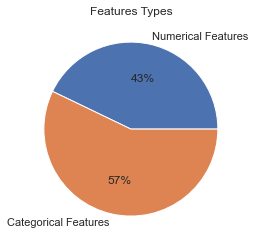

In [10]:
m_describe.show_main(dtl)

# Handling missing values

In [11]:
m_describe.missing_val_list(dtl)

,Feature,Type,count of nulls,null % of total obesrvations
0,Age,Numerical,270,2.00
1,RoomService,Numerical,263,2.00
2,FoodCourt,Numerical,289,2.00
3,ShoppingMall,Numerical,306,2.00
4,Spa,Numerical,284,2.00
5,VRDeck,Numerical,268,2.00
6,HomePlanet,Categorical,288,2.00
7,CryoSleep,Categorical,310,2.00
8,Cabin,Categorical,299,2.00
9,Destination,Categorical,274,2.00


In [12]:
from sklearn.impute import MissingIndicator, SimpleImputer, IterativeImputer

In [27]:
dtl[var_num].head(2)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.00,0.00,0.00,0.00,0.00,0.00
1,24.00,109.00,9.00,25.00,549.00,44.00


In [44]:
dtl = pd.concat([dtr,dts],axis=0)

In [45]:
dtl.isnull().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

In [46]:
a = SimpleImputer(strategy='median')

In [47]:
dtl[var_num] = a.fit_transform(dtl[var_num])

In [48]:
b = SimpleImputer(strategy='most_frequent')

In [49]:
dtl[var_cat] = b.fit_transform(dtl[var_cat])

In [50]:
dtl.isnull().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name               0
Transported     4277
dtype: int64

In [16]:
var_num = m_describe.num(dtl)
var_cat = m_describe.cat(dtl)
var_cat.remove('Transported')

In [18]:
for i in range( len(var_num) ):
    var = var_num[i]
    print (var)
    dtl[var].fillna(dtl[var].mean(),inplace=True)

Age
RoomService
FoodCourt
ShoppingMall
Spa
VRDeck


In [19]:
for i in range( len(var_cat) ):
    var = var_cat[i]
    print (var)
    dtl[var].fillna(dtl[var].mode()[0],inplace=True)

PassengerId
HomePlanet
CryoSleep
Cabin
Destination
VIP
Name


In [20]:
m_describe.missing_val_list(dtl)

,Feature,Type,count of nulls,null % of total obesrvations
0,Transported,Categorical,4277,33.00


# Check Cardinality

In [31]:
m_describe.show_category_concentration(dtl,0)

,Feature,Unique values,1st category concentration -%
0,VIP,2,98.00
1,CryoSleep,2,65.00
2,Transported,2,50.00
3,Destination,3,71.00
4,HomePlanet,3,55.00
5,Age,81,4.00
6,ShoppingMall,1368,64.00
7,RoomService,1579,64.00
8,VRDeck,1643,64.00
9,Spa,1680,61.00


# Splitting all data back

In [21]:
dtr.shape

(8693, 14)

In [22]:
dtrnull = dtl.iloc[0:8693,]
dtsnull = dtl.iloc[8693:,]
dtsnull.drop(labels=['Transported'],axis=1,inplace=True)

In [23]:
dtrnull.shape,dtsnull.shape

((8693, 14), (4277, 13))

In [24]:
dtr.shape,dts.shape

((8693, 14), (4277, 13))

# Modeling Raw Data

In [25]:
var_num

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [26]:
var_cat

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name']

In [32]:
dftrain = dtrnull
dftest = dtsnull
num_feature=var_num
cat_feature=['HomePlanet','CryoSleep','Destination','VIP']

xtr_sc,xts_sc,ytr,yts,dfts_sc = m_scale_encode_split(dftrain=dftrain,target_feature='Transported',num_feature=num_feature,
                                                     cat_feature=cat_feature,train_size=0.85,dftest=dftest,
                                                     encode_target=1)

In [34]:
model = LazyClassifier()
model.fit(xtr_sc,xts_sc,ytr,yts)

100%|██████████| 29/29 [00:16<00:00,  1.74it/s]

[LightGBM] [Info] Number of positive: 3745, number of negative: 3644
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1374
[LightGBM] [Info] Number of data points in the train set: 7389, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506834 -> initscore=0.027340
[LightGBM] [Info] Start training from score 0.027340


(                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
 Model                                                                           
 LinearSVC                          0.80               0.80     0.80      0.80   
 CalibratedClassifierCV             0.80               0.80     0.80      0.80   
 LogisticRegression                 0.80               0.80     0.80      0.80   
 LGBMClassifier                     0.80               0.80     0.80      0.80   
 XGBClassifier                      0.79               0.80     0.80      0.79   
 AdaBoostClassifier                 0.79               0.79     0.79      0.79   
 NuSVC                              0.79               0.79     0.79      0.79   
 SVC                                0.78               0.78     0.78      0.78   
 RidgeClassifierCV                  0.78               0.77     0.77      0.78   
 LinearDiscriminantAnalysis         0.78               0.77     0.77      0.78   
 RidgeClassifier

In [51]:
m_mlog_regression(xtr_sc,xts_sc,ytr,yts)

,index,Model,Type,Scaled,Score
0,0,Logistic,General,Yes,0.80
1,7,LGBM Classifier,General,Yes,0.80
2,8,CatBoost Classifier,General,Yes,0.80
3,6,XGB Classifier,General,Yes,0.79
4,3,SVC,General,Yes,0.78
5,5,RandomForest,General,Yes,0.77
6,1,Kneighbors,General,Yes,0.75
7,4,DecisionTree,General,Yes,0.73
8,2,GaussianNB,General,Yes,0.69


# Hyperparameter tuning

In [99]:
#Logistic

estimator = LogisticRegression()
param_grid={'penalty':['l1', 'l2', 'elasticnet'],
            'C':[1,1.1 , 1.2, 1.5, 2],
            'fit_intercept':[True, False],
            'solver':['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
            'multi_class':['auto', 'ovr', 'multinomialp']
           }

In [100]:
cvmodel = GridSearchCV(estimator=estimator,param_grid=param_grid)

In [101]:
cvmodel.fit(xtr_sc,ytr)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [1, 1.1, 1.2, 1.5, 2],
                         'fit_intercept': [True, False],
                         'multi_class': ['auto', 'ovr', 'multinomialp'],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag',
                                    'saga']})

In [102]:
cvmodel.best_score_

0.7857616515941779

In [103]:
cvmodel.best_params_

{'C': 1.1,
 'fit_intercept': True,
 'multi_class': 'auto',
 'penalty': 'l1',
 'solver': 'saga'}

In [104]:
scores = cross_val_score(estimator=estimator,X=xtr_sc,y=ytr,cv=10)

In [105]:
scores.min(),scores.max()

(0.7523680649526387, 0.8092016238159675)

In [108]:
ypr = cvmodel.predict(xts_sc)

In [121]:
fpr, tpr, thresholds= roc_curve(yts, ypr)

In [123]:
auc = roc_auc_score(yts, ypr)

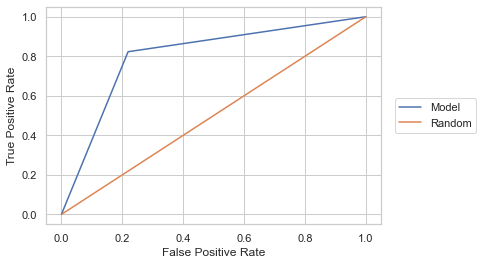

In [146]:
plt.plot(fpr, tpr, label='Model');
plt.plot([0,1],[0,1], label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate");
plt.legend(loc="right", bbox_to_anchor=(1.3, 0.5));


# Modelling full data

In [272]:
dftrain = dtrnull
dftest = dtsnull
num_feature=var_num
cat_feature=['HomePlanet','CryoSleep','Destination','VIP']

xtr_sc,xts_sc,ytr,yts,dfts_sc = m_scale_encode_split(dftrain=dftrain,target_feature='Transported',num_feature=num_feature,
                                                     cat_feature=cat_feature,train_size=100,dftest=dftest,
                                                     encode_target=1)

train size is 100%


In [273]:
model_final = LogisticRegression(C=1.1,fit_intercept=True, multi_class= 'auto', penalty= 'l1', solver= 'saga')

In [274]:
model_final.fit(xtr_sc,ytr)

LogisticRegression(C=1.1, penalty='l1', solver='saga')

In [275]:
ypr_final = model_final.predict(dfts_sc)

In [276]:
df_sub = dftest.copy()
df_sub = dftest[['PassengerId']]
df_sub['Transported'] = ypr_final

In [277]:
df_sub.to_csv('11.csv',index=False)